In [13]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [14]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [15]:
pre_pandemic_months = ['2019-04'
                       '2019-05'
                       '2019-06',
                       '2019-07',
                       '2019-08',
                       '2019-09',
                       '2019-10',
                       '2019-11',
                       '2019-12',
                       '2020-01',
                       '2020-02',
                       '2020-03']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [16]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m        0.000000e+00   
                                                 pre_treatment_change_in_group_0_crimes_500m       7.582878e-30   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                3.422876e-01   
                                                 job_density_2013                                  4.308928e-70   
                                                 med_hhinc2016                                     6.483431e-02   
                                                 poor_share2010                                    3.191906e-08   
                                                 popdensity2010                                    4.172430e-16   
Panel C: Case Initiation                         for_cause                                         3.092618e-02   
                                                 no_cause                                          1.799753e-02   
                                                 non_payment                                       9.476483e-04   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          2.475857e-01   
                                                 hasAttyP                                          3.777658e-01   
                                                 isEntityD                                         5.942610e-06   
                                                 isEntityP                                         2.182365e-02   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m   0.532747  
                                                 pre_treatment_change_in_group_0_crimes_500m  0.342754  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.026586  
                                                 job_density_2013                             0.285288  
                                                 med_hhinc2016                                0.006887  
                                                 poor_share2010                               0.007088  
                                                 popdensity2010                               0.568300  
Panel C: Case Initiation                         for_cause                                    0.000297  
                                                 no_cause                                     0.160724  
                                                 non_payment                                  0.035557  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.000018  
                                                 hasAttyP                                     0.057909  
                                                 isEntityD                                    0.129970  
                                                 isEntityP                                    0.001203

In [17]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1211.420245   
        Change in Crime Incidents, 2017-2019            -162.362986   
Panel B Job density, 2013                              17879.131663   
        Poverty rate, 2010                                 0.284488   
        Population density, 2010                       23692.018106   
Panel C Filing for cause                                   0.152352   
        Filing without cause                               0.043967   
        Filing for nonpayment                              0.803681   
Panel D Defendant is entity                                0.016360   
        Plaintiff is entity                                0.824131   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                     22.702503   
        Change in Crime Incidents, 2017-2019                           -10.762986   
Panel B Job density, 2013                                             2380.874938   
        Poverty rate, 2010                                              -0.020869   
        Population density, 2010                                       403.429752   
Panel C Filing for cause                                                 0.062029   
        Filing without cause                                            -0.015710   
        Filing for nonpayment                                           -0.041480   
Panel D Defendant is entity                                             -0.011059   
        Plaintiff is entity                                             -0.059740   

                                                                             
                                              \emph{p}   Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.532747   3.528841  0.923483  
        Change in Crime Incidents, 2017-2019  0.342754  -0.236573  0.983399  
Panel B Job density, 2013                     0.285288 -10.559455  0.996213  
        Poverty rate, 2010                    0.007088   0.001631  0.815408  
        Population density, 2010              0.568300  70.256498  0.921652  
Panel C Filing for cause                      0.000297  -0.001368  0.922863  
        Filing without cause                  0.160724   0.000634  0.954196  
        Filing for nonpayment                 0.035557   0.004072  0.826965  
Panel D Defendant is entity                   0.129970   0.000396  0.955994  
        Plaintiff is entity                   0.001203   0.004703  0.763362

In [18]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [19]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 920/920 [00:10<00:00, 90.95it/s] 


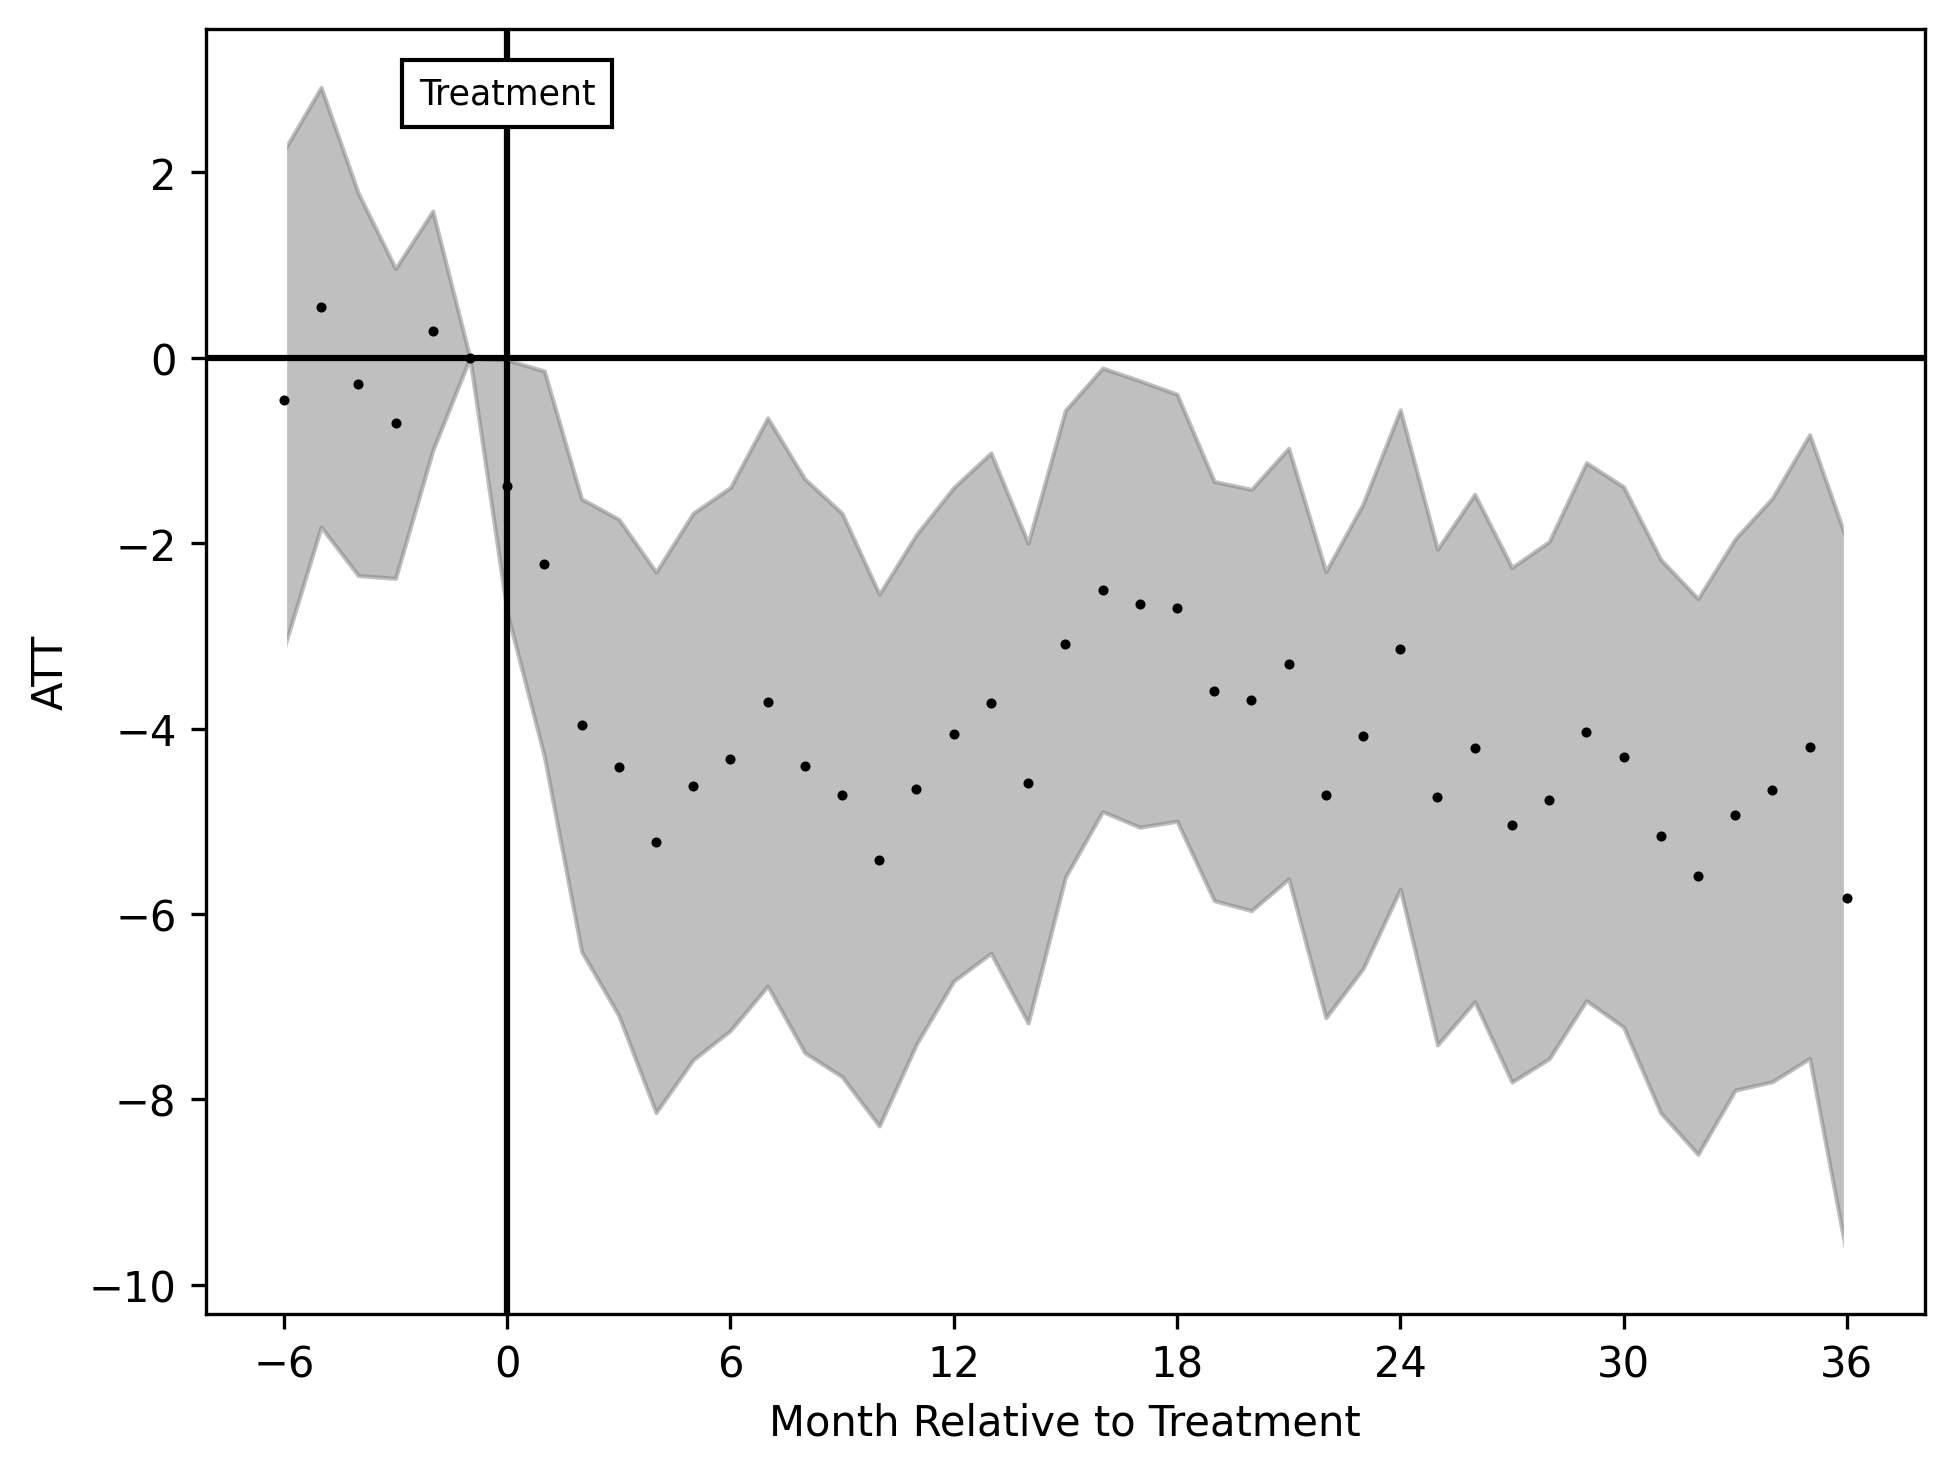

In [20]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

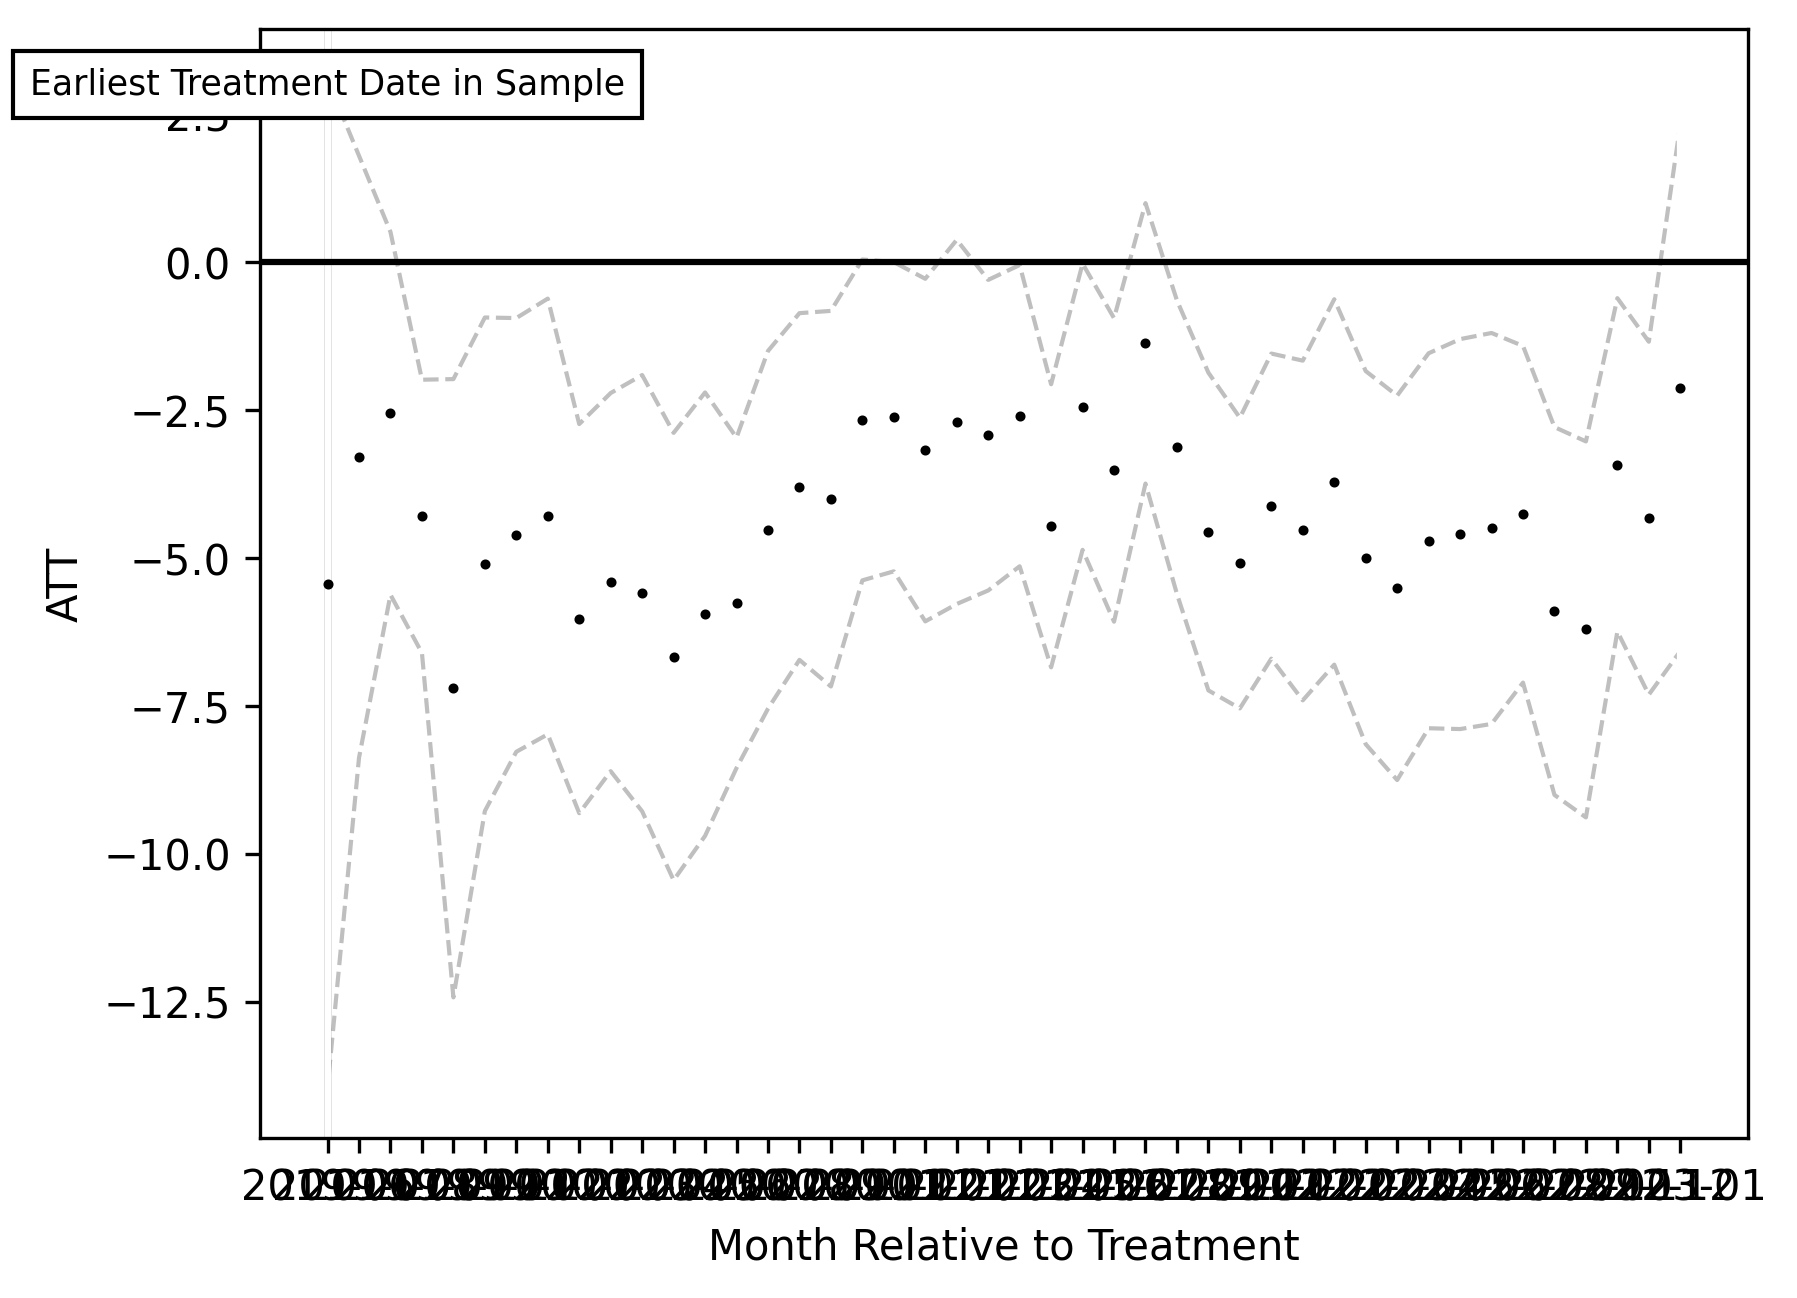

In [21]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [22]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 920/920 [00:31<00:00, 29.62it/s]


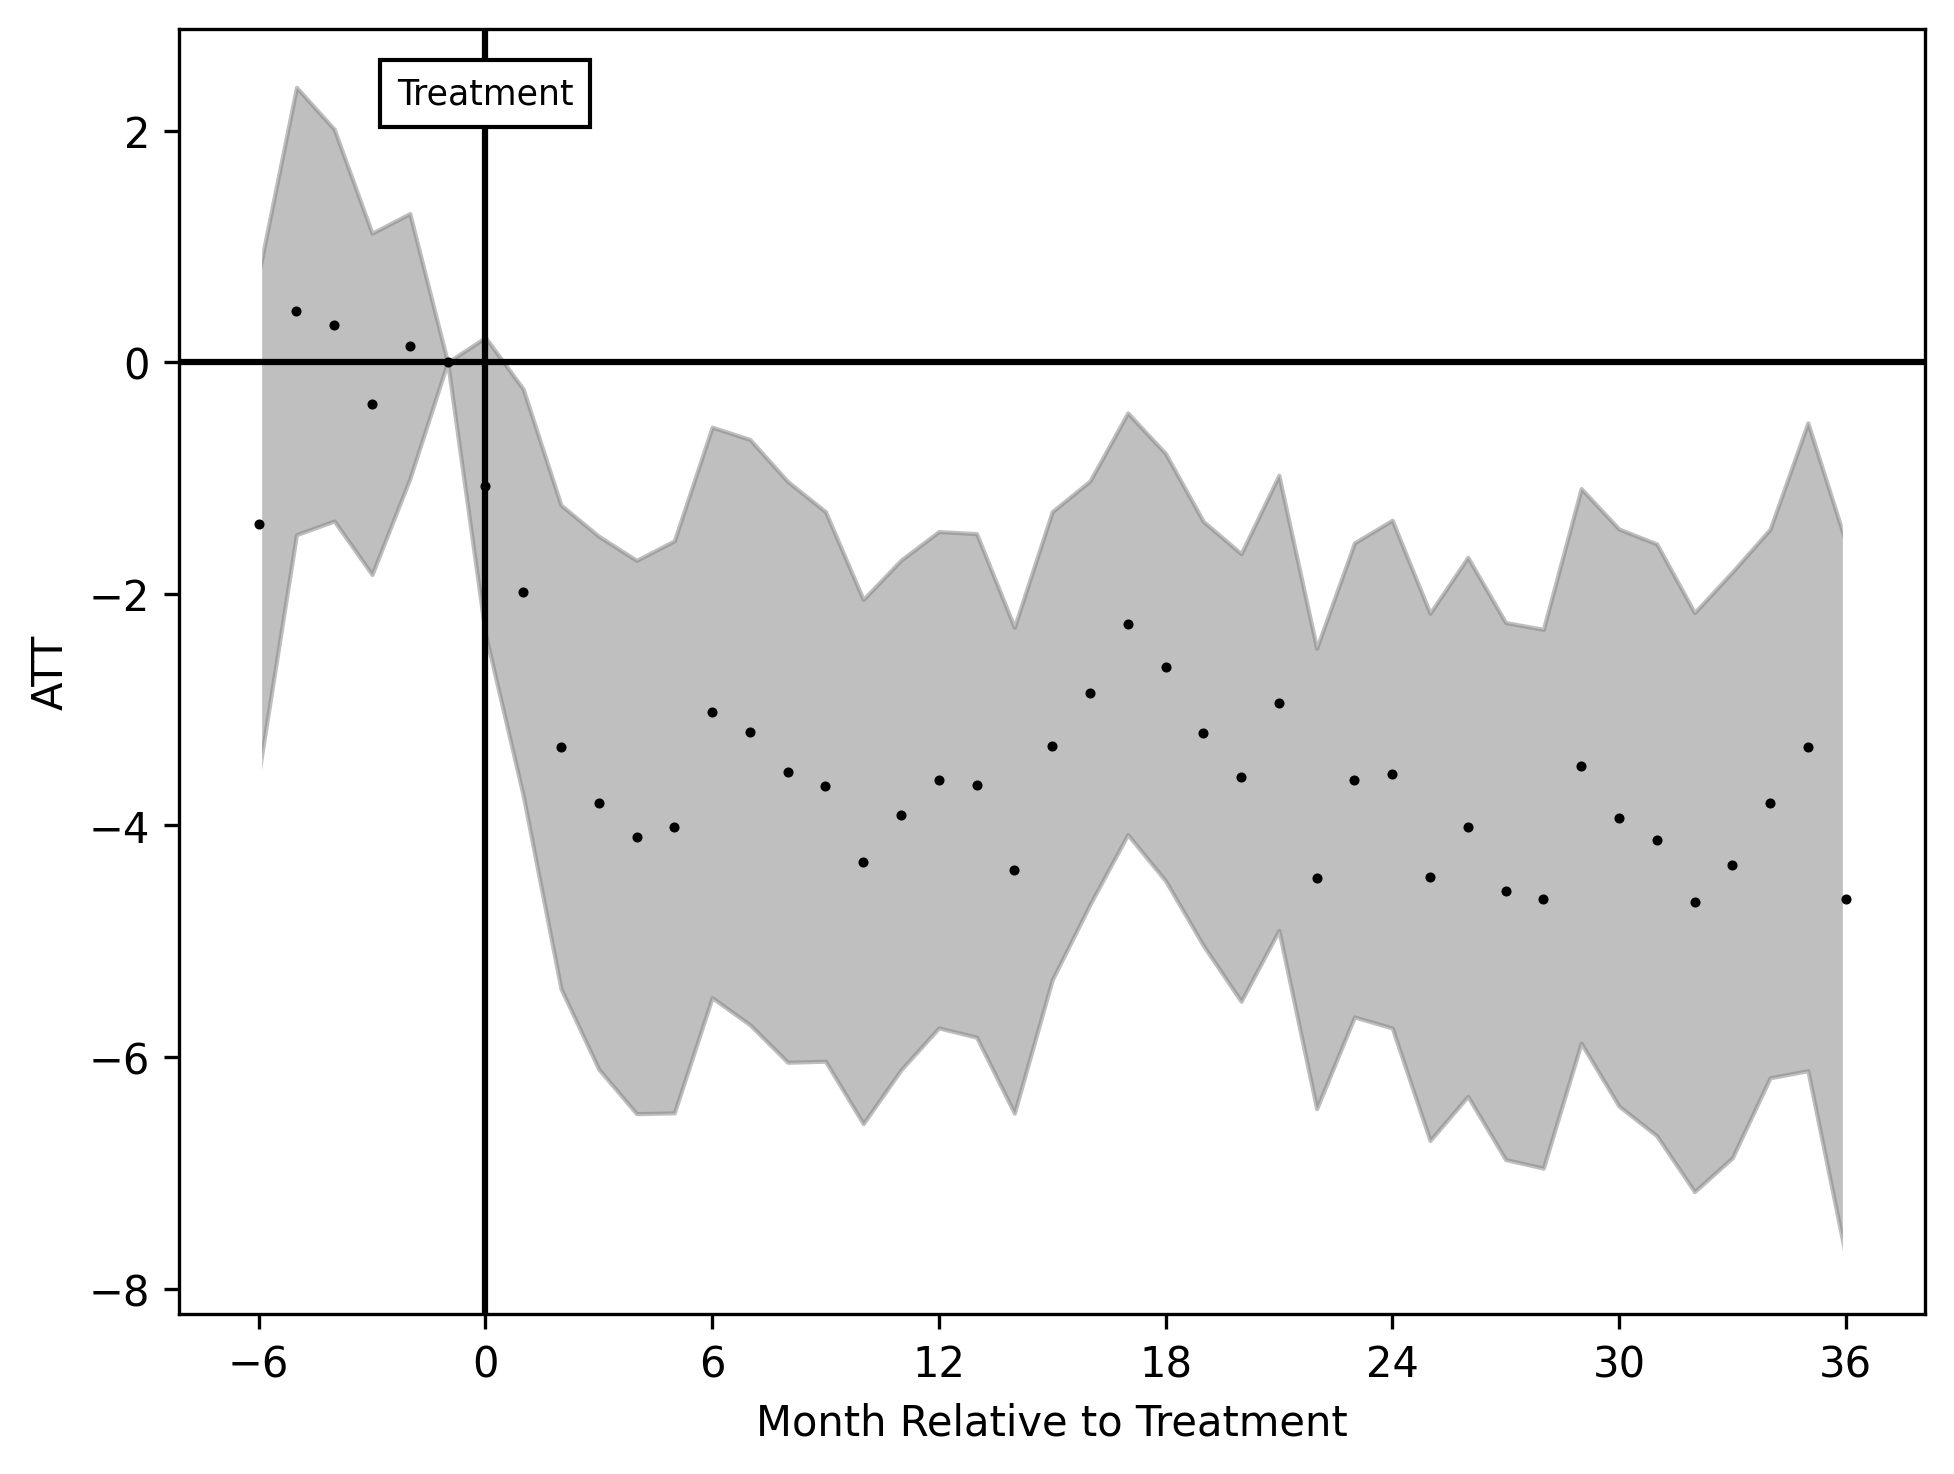

In [23]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

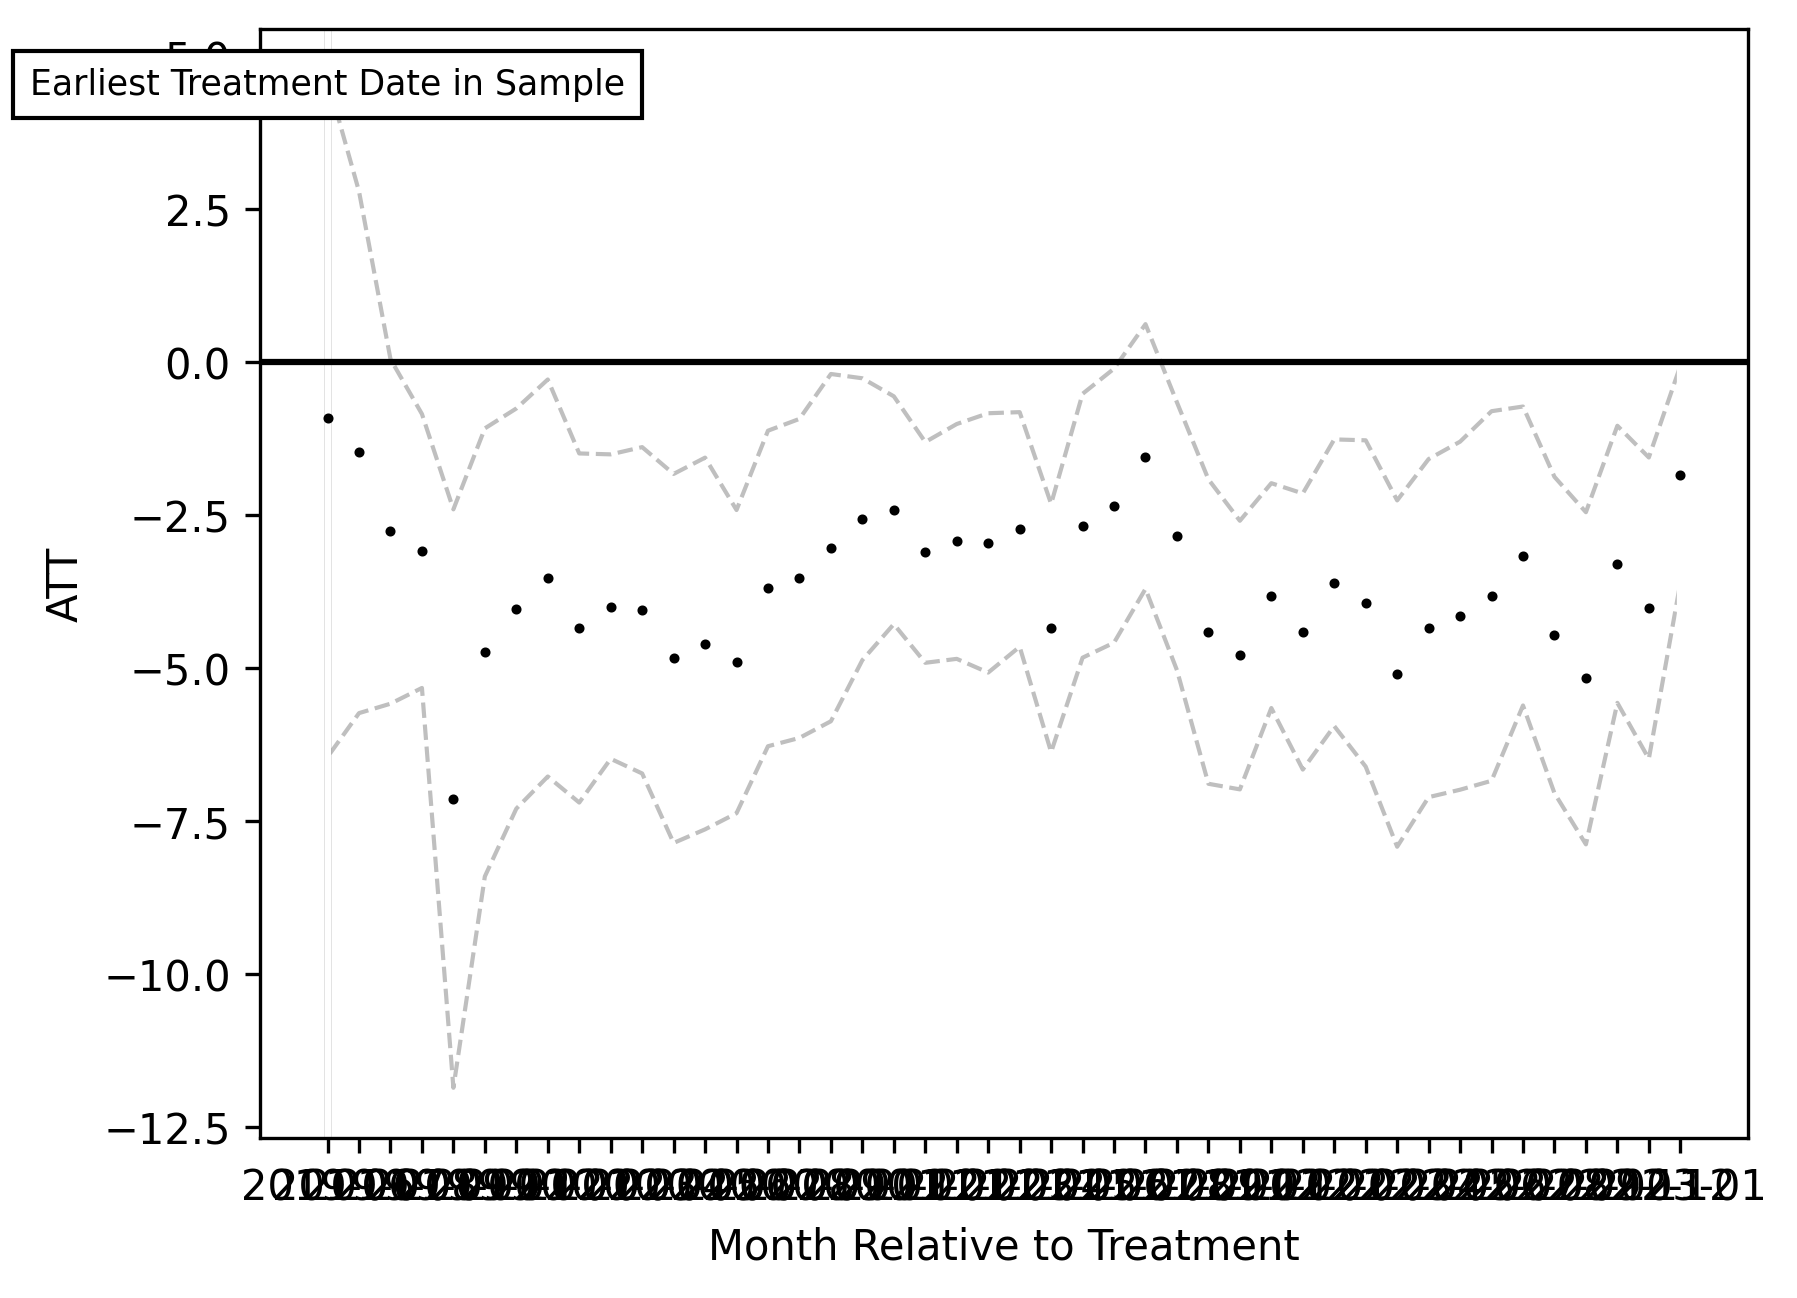

In [24]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")